## **Medical Classification**
    Jad Alaouie
    Joe Nouaime
    Tia Manoukian

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


%pip install datasets
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, Trainer, TrainingArguments
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch

# Make sure to restart the kernel if you're using google colab.
%pip install accelerate>=0.21.0

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional, BatchNormalization,SpatialDropout1D, SimpleRNN, GRU
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1_l2
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import regularizers
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import SGD


In [2]:
# Reading the new pre-processed and augmented data (code available in Data Pre-Processing.ipynb)
new_data = pd.read_csv('/content/new_data.csv')

In [3]:
new_data.head()

,condition_label,medical_abstract
0,5,ting bipolar hemi arth roplasty subc ap ital f...
1,5,receive ting bipolar hemi arth roplasty subc a...
2,5,ting bipolar hemi arth roplasty subc ap ital f...
3,5,stool contain altered rake plasma urea creatin...
4,5,stool hold change rake plasma urea creatinine ...


In [4]:
new_data = new_data.sample(frac=1)

In [5]:
# Split dataset into 60% Train set, 20% Validation set, 20% Test set.
X_train, X_test, y_train, y_test = train_test_split(new_data['medical_abstract'],
                                                         new_data['condition_label'],
                                                         test_size = 0.2,
                                                         random_state = 42,
                                                         shuffle = True)

X_train, X_validation, y_train, y_validation = train_test_split(X_train,
                                                         y_train,
                                                         test_size = 0.2,
                                                         random_state = 42,
                                                         shuffle = True)

In [6]:
# TF-IDF Vectorizer to convert text data into a matrix of TF-IDF features.
tfidf_vectorizer = TfidfVectorizer()

# Fitting the vectorizer to the training data and transform it into a TF-IDF-weighted document-term matrix.
X_train = tfidf_vectorizer.fit_transform(X_train)

# Transforming the validation and test datasets using the already fitted TF-IDF vectorizer.
X_validation = tfidf_vectorizer.transform(X_validation)
X_test = tfidf_vectorizer.transform(X_test)

In [7]:
# Calculating the number of words in each 'medical_abstract' and store the results in a new column 'sentence_length'.
new_data['sentence_length'] = new_data['medical_abstract'].apply(lambda x: len(x.split()))

In [8]:
# Max sentence length in the dataset.
max_sentence_length = new_data['sentence_length'].max()
print("Maximum sentence length: ", max_sentence_length)

# Average sentence length in the dataset.
average_sentence_length = new_data['sentence_length'].mean()
print("average sentence length: ", average_sentence_length)

Maximum sentence length:  473
average sentence length:  142.9561111111111


**Learning Curve**

In [9]:
# code extracted from the official website of sklearn.
def plot_learning_curve(estimator, title, X_train, y_train, X_val, y_val, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X_train : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y_train : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X_train for classification or regression.

    X_val : array-like, shape (n_samples, n_features)
        Validation vector, where n_samples is the number of samples and
        n_features is the number of features.

    y_val : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X_val for classification or regression.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum y-values plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually has to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_train, y_train, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


**Logistic Regression:**

In [10]:
logistic_regression = LogisticRegression(multi_class = 'auto',
                                         solver = 'newton-cg',
                                         penalty = 'l2',
                                         C = 6)

logistic_regression = logistic_regression.fit(X_train, y_train)

In [11]:
validation_predictions = logistic_regression.predict(X_validation)
train_predictions = logistic_regression.predict(X_train)

validation_accuracy = accuracy_score(y_validation, validation_predictions)
train_accuracy = accuracy_score(y_train, train_predictions)

print("Accuracy Score for Train Data: ", train_accuracy)
print("Accuracy Score for Validation Data: ", validation_accuracy)

Accuracy Score for Train Data:  0.9449305555555556
Accuracy Score for Validation Data:  0.8644444444444445


**Learning Curve**

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


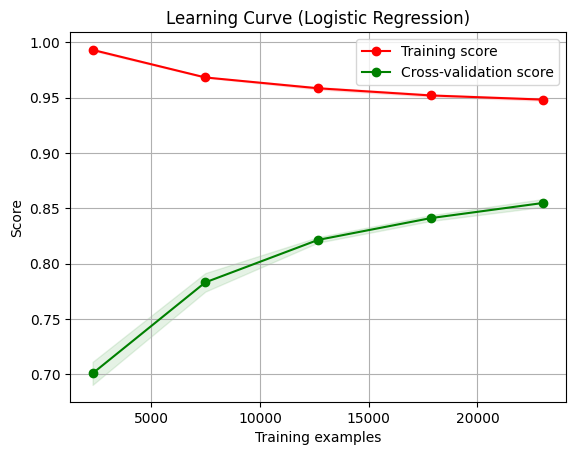

In [12]:
title = "Learning Curve (Logistic Regression)"
plot_learning_curve(logistic_regression, title, X_train, y_train,
                    X_validation, y_validation, cv=5, n_jobs=-1)
plt.show()

**Model Performance on Test Data**

In [13]:
test_predictions = logistic_regression.predict(X_test)

test_accuracy = accuracy_score(y_test, test_predictions)

print("Accuracy Score for Test Data: ", test_accuracy)

Accuracy Score for Test Data:  0.8686666666666667


**Confusion Matrix**

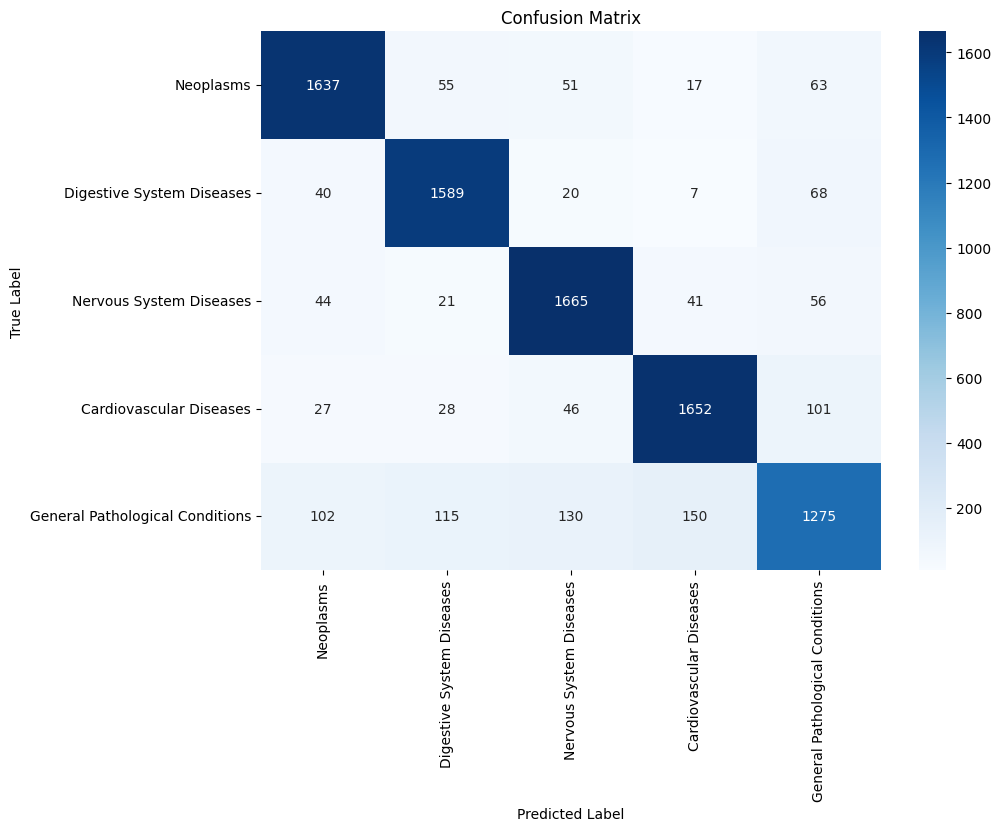

In [14]:
test_predictions = logistic_regression.predict(X_test)

cm = confusion_matrix(y_test, test_predictions)

class_names = ['Neoplasms', 'Digestive System Diseases', 'Nervous System Diseases', 'Cardiovascular Diseases', 'General Pathological Conditions']
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

**Classification Report**

In [15]:
report = classification_report(test_predictions, y_test)
print(report)

              precision    recall  f1-score   support

           1       0.90      0.88      0.89      1850
           2       0.92      0.88      0.90      1808
           3       0.91      0.87      0.89      1912
           4       0.89      0.88      0.89      1867
           5       0.72      0.82      0.76      1563

    accuracy                           0.87      9000
   macro avg       0.87      0.87      0.87      9000
weighted avg       0.87      0.87      0.87      9000



**Support Vector Machine**

In [ ]:
svc = SVC(kernel = 'linear', C = 1.0)
svc.fit(X_train, y_train)

svc_predictions = svc.predict(X_validation)
train_predictions = svc.predict(X_train)

validation_accuracy = accuracy_score(y_validation, svc_predictions)
train_accuracy = accuracy_score(y_train, train_predictions)

print("Accuracy Score for Train Data: ",train_accuracy)
print("Accuracy Score for Validation Data: ",validation_accuracy)

**Hyper Parameter Tuning**

In [ ]:
parameters = {
    'kernel' : ['sigmoid', 'linear','poly'],
    'C' : [0.1, 1, 3, 5,10],
    'gamma' : [0.1, 0.3, 0.9],
    'class_weight' : ['balanced']
}

grid_search = GridSearchCV(svc, parameters, cv = 5, scoring = 'accuracy')
grid_search.fit(X_train, y_train)

best_svm  = grid_search.best_estimator_
validation_accuracy = best_svm.score(X_validation, y_validation)

In [ ]:
print(best_svm)
print(validation_accuracy)

**Learning Curve**


In [ ]:
title = "Learning Curve (Support Vector Machine)"

plot_learning_curve(svc, title, X_train, y_train,
                    X_validation, y_validation, cv=5, n_jobs=-1)

plt.show()

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


**Best Model Performance on Test Data**

In [ ]:
# Fitting Support Vector Machine with the best parameters
svc = SVC(kernel = 'linear', C = 10)

svc.fit(X_train, y_train)

test_predictions = svc.predict(X_test)

test_accuracy = accuracy_score(y_test, test_predictions)

print("Accuracy Score for Test Data: ", test_accuracy)

Accuracy Score for Test Data:  0.8744444444444445


**Confusion Matrix**

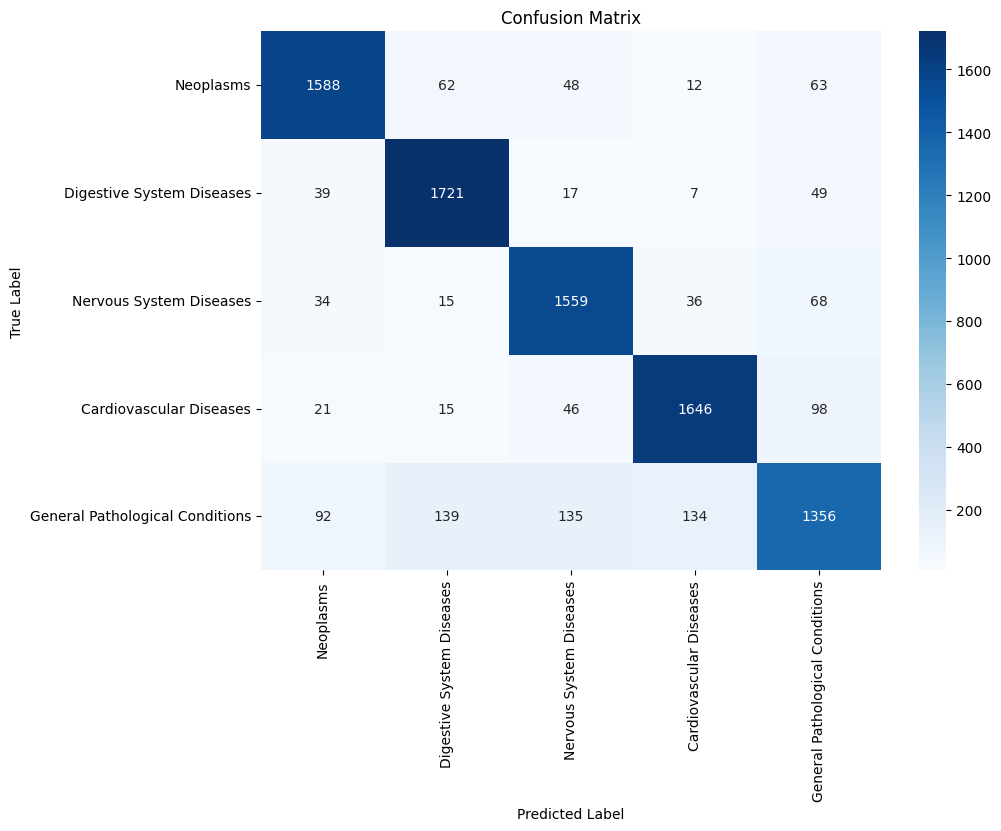

In [ ]:
cm = confusion_matrix(y_test, test_predictions)

class_names = ['Neoplasms', 'Digestive System Diseases', 'Nervous System Diseases', 'Cardiovascular Diseases', 'General Pathological Conditions']

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

**Classification Report**

In [ ]:
report = classification_report(test_predictions, y_test)
print(report)

              precision    recall  f1-score   support

           1       0.90      0.90      0.90      1774
           2       0.94      0.88      0.91      1952
           3       0.91      0.86      0.89      1805
           4       0.90      0.90      0.90      1835
           5       0.73      0.83      0.78      1634

    accuracy                           0.87      9000
   macro avg       0.88      0.87      0.87      9000
weighted avg       0.88      0.87      0.88      9000



**XGBOOST**

In [17]:
y_train = y_train - 1
y_validation = y_validation - 1
y_test = y_test - 1

In [ ]:
xgb_classifier = xgb.XGBClassifier(
    objective = 'multi-softmax',
    num_class = len(set(y_train)),
    seed = 42,
    max_depth = 5,
    min_child_weight = 1,
    gamma = 0,
    subsample = 0.8,
    colsample_bytree = 0.8,
    eta = 0.3
)

xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=5, ...)

In [ ]:
y_train_pred = xgb_classifier.predict(X_train)
y_validation_pred = xgb_classifier.predict(X_validation)

train_accuracy = accuracy_score(y_train, y_train_pred)
validation_accuracy = accuracy_score(y_validation, y_validation_pred)

print("Accuracy Score for Train Data: ", train_accuracy)
print("Accuracy Score for Validation Data: ", validation_accuracy)

Accuracy Score for Train Data:  0.9155555555555556
Accuracy Score for Validation Data:  0.8309722222222222


**Learning Curve**

In [ ]:
title = "Learning Curve (Xgboost)"
plot_learning_curve(xgb_classifier, title, X_train, y_train,
                    X_validation, y_validation, cv=5, n_jobs=-1)
plt.show()

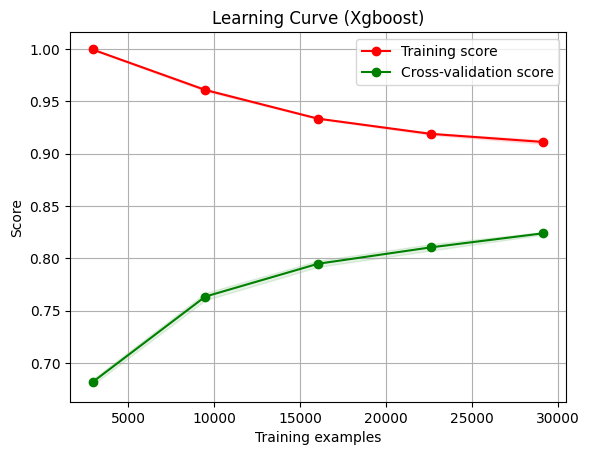

**Hyper-Parameter Tuning**

In [ ]:
# Parameter grid for grid search
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'eta': [0.1, 0.2, 0.3]
}

# Perform grid search
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy score found: ", grid_search.best_score_)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


**Best Model Performance on Test Data**

In [18]:
xgb_classifier = xgb.XGBClassifier(
    colsample_bytree = 0.8,
    eta = 1.0,
    gamma = 0.1,
    max_depth = 5,
    min_child_weight = 3,
    subsample = 0.8
)

xgb_classifier.fit(X_train, y_train)

test_predictions = xgb_classifier.predict(X_test)
print("Accuracy Score on Test Data: ", accuracy_score(y_test, test_predictions))

**Confusion Matrix**

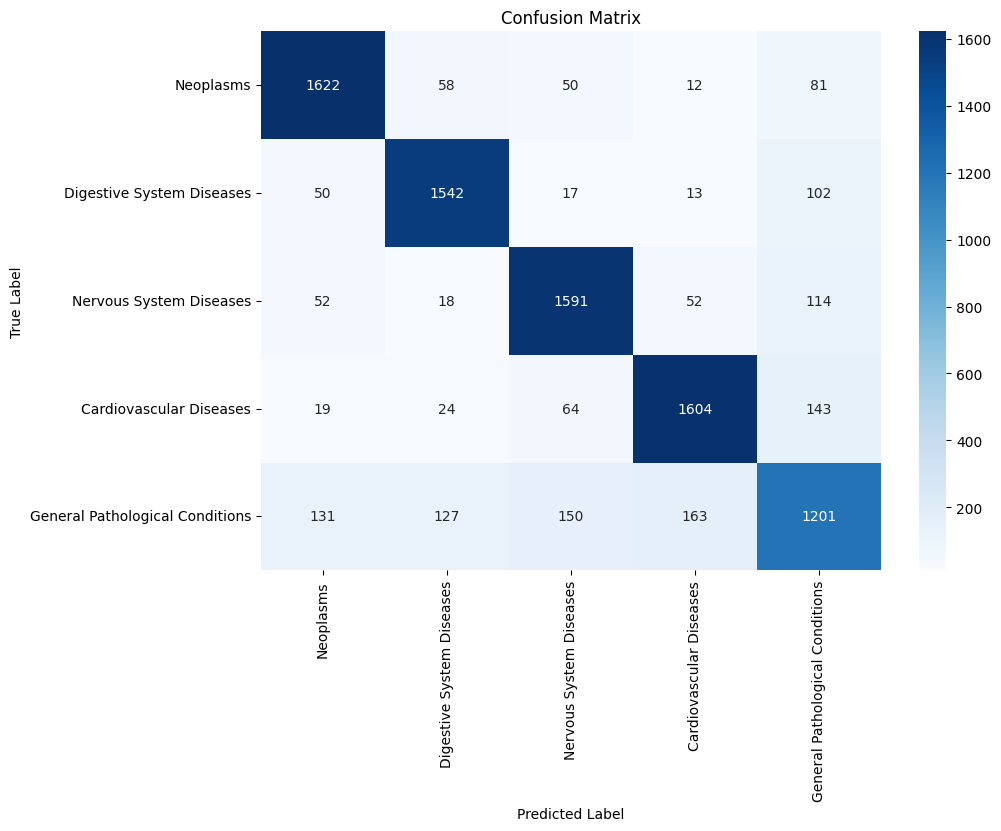

In [19]:
cm = confusion_matrix(y_test, test_predictions)
class_names = ['Neoplasms', 'Digestive System Diseases', 'Nervous System Diseases', 'Cardiovascular Diseases', 'General Pathological Conditions']
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

**Classification Report**

In [21]:
class_names = ['Neoplasms', 'Digestive System Diseases', 'Nervous System Diseases', 'Cardiovascular Diseases', 'General Pathological Conditions']

report = classification_report(y_test, test_predictions, target_names=class_names)

print("Classification Report:\n", report)

Classification Report:
                                  precision    recall  f1-score   support

                      Neoplasms       0.87      0.89      0.88      1823
      Digestive System Diseases       0.87      0.89      0.88      1724
        Nervous System Diseases       0.85      0.87      0.86      1827
        Cardiovascular Diseases       0.87      0.87      0.87      1854
General Pathological Conditions       0.73      0.68      0.70      1772

                       accuracy                           0.84      9000
                      macro avg       0.84      0.84      0.84      9000
                   weighted avg       0.84      0.84      0.84      9000



**Transformers using BERT:**

In [ ]:
new_data = pd.read_csv('/content/new_data.csv')

In [ ]:
# Converting medical abstracts and condition labels to lists.
records = new_data['medical_abstract'].tolist()
labels = new_data['condition_label'].tolist()

In [ ]:
# Splitting the data into training, testing and validation sets.
# 60% for Training set, 20% for Testing set and 20% for Validation set.
train_records, test_records, train_labels, test_labels = train_test_split(records,
                                                                          labels,
                                                                          test_size = 0.2,
                                                                          random_state = 42)

train_records, validation_records, train_labels, validation_labels = train_test_split(train_records,
                                                                                      train_labels,
                                                                                      test_size= 0.2,
                                                                                      random_state= 42)

In [ ]:
# Token initialization with pretrained BERT model specialized for biomedical text.
tokenizer = BertTokenizer.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

In [ ]:
# Tokenizing and encoding the data for training, validation and testing.
train_encodings = tokenizer(train_records, truncation = True, padding = True, max_length= 512)
validation_encodings = tokenizer(validation_records, truncation = True, padding = True, max_length = 512)
test_encodings = tokenizer(test_records, truncation = True, padding = True, max_length= 512)

In [ ]:
# Converting labels into tensors and adjusting indices
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)
validation_labels = torch.tensor(validation_labels)

train_labels = train_labels - 1
test_labels = test_labels - 1
validation_labels = validation_labels - 1

In [ ]:
# Creating datasets from the tokenized texts and the adjusted labels for use in DataLoader.
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})

validation_dataset = Dataset.from_dict({
    'input_ids': validation_encodings['input_ids'],
    'attention_mask': validation_encodings['attention_mask'],
    'labels': validation_labels
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_labels
})

In [ ]:
# Setting up DataLoaders to manage batches of data during training and validation.
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False)
validation_loader = DataLoader(validation_dataset, batch_size = 16, shuffle = False)

In [ ]:
# Loading the BERT model for sequence classification, specifying the number of unique labels.
model = BertForSequenceClassification.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract', num_labels=len(set(new_data['condition_label'])))

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
# Set the device for training (GPU if available).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

NameError: name 'model' is not defined

In [ ]:
# Making sure we're benefiting from the GPU.
print("Using: ", device)

In [ ]:
# Configuring the optimizer.
optimizer = AdamW(model.parameters(), lr = 3e-04)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Defining the training parameters, including directory for outputs, batch sizes, number of epochs, and evaluation strategy.
training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=16,
    per_device_eval_batch_size= 16,
    num_train_epochs=13,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=1000,
    save_steps=1000,
    load_best_model_at_end=True,
    learning_rate=3e-04,
    resume_from_checkpoint= 'checkpoint-19000'
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train(resume_from_checkpoint = '/content/results/checkpoint-19000')

Step,Training Loss,Validation Loss,Accuracy
20000,0.063000,0.869904,0.875556
21000,0.103700,0.911101,0.872500
22000,0.032000,0.918947,0.872778


Step,Training Loss,Validation Loss,Accuracy
20000,0.063000,0.869904,0.875556
21000,0.103700,0.911101,0.872500
22000,0.032000,0.918947,0.872778
23000,0.041000,0.947457,0.873472


TrainOutput(global_step=23400, training_loss=0.01200609803199768, metrics={'train_runtime': 2326.9655, 'train_samples_per_second': 160.896, 'train_steps_per_second': 10.056, 'total_flos': 9.85114325385216e+16, 'train_loss': 0.01200609803199768, 'epoch': 13.0})

**Bert Performance on Test Data**

In [ ]:
model_path = '/content/results/checkpoint-23000'
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=
                                                      len(set(new_data['condition_label'])))

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics
)

test_results = trainer.evaluate(test_dataset)

print("Test Accuracy: ", test_results['eval_accuracy'])

Test Loss:  0.994253933429718
Test Accuracy:  0.8681111111111111


**Confusion Matrix**

In [ ]:
predictions_output = trainer.predict(test_dataset)

predictions = np.argmax(predictions_output.predictions, axis = 1)
actuals = predictions_output.label_ids

In [ ]:
cm = confusion_matrix(actuals,  predictions)

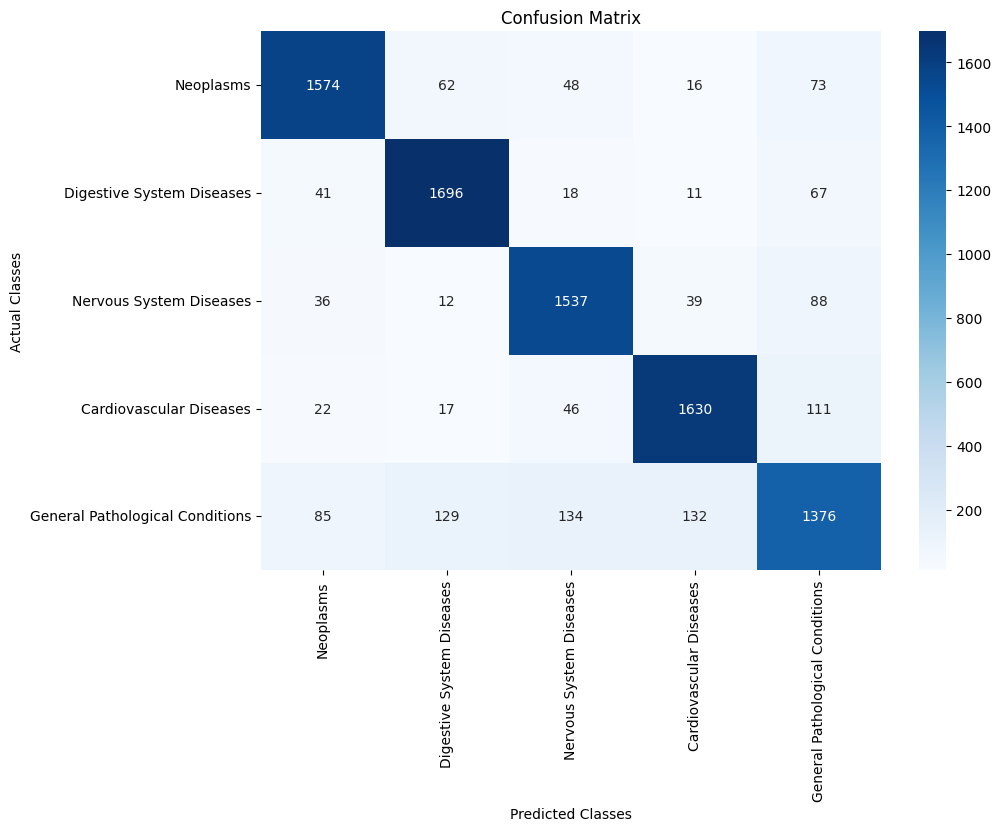

In [ ]:
class_names = ['Neoplasms', 'Digestive System Diseases', 'Nervous System Diseases', 'Cardiovascular Diseases', 'General Pathological Conditions']

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')
plt.show()

In [ ]:
class_names = ['Neoplasms', 'Digestive System Diseases', 'Nervous System Diseases', 'Cardiovascular Diseases', 'General Pathological Conditions']

report = classification_report(actuals, predictions, target_names=class_names)

print("Classification Report:\n", report)

Classification Report:
                                  precision    recall  f1-score   support

                      Neoplasms       0.90      0.89      0.89      1773
      Digestive System Diseases       0.89      0.93      0.90      1833
        Nervous System Diseases       0.86      0.90      0.88      1712
        Cardiovascular Diseases       0.89      0.89      0.89      1826
General Pathological Conditions       0.80      0.74      0.77      1856

                       accuracy                           0.87      9000
                      macro avg       0.87      0.87      0.87      9000
                   weighted avg       0.87      0.87      0.87      9000



**Recurrent Neural Networks**

In [4]:
new_data = pd.read_csv('/content/new_data.csv')

In [5]:
new_data = new_data.sample(frac=1)

In [6]:
# Splitting the data into 60% Train set, 20% Test set and 20% Validation set.
X_train, X_test, y_train, y_test = train_test_split(new_data['medical_abstract'],
                                                         new_data['condition_label'],
                                                         test_size = 0.2,
                                                         random_state = 42,
                                                         shuffle = True)

X_train, X_validation, y_train, y_validation = train_test_split(X_train,
                                                         y_train,
                                                         test_size = 0.2,
                                                         random_state = 42,
                                                         shuffle = True)

In [7]:
# Initializing the tokenizer and fitting it on the training data to prepare for sequence transformation.
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train)

# Converting texts to sequences to be processed by neural networks.
train_sequences = tokenizer.texts_to_sequences(X_train)
validation_sequences = tokenizer.texts_to_sequences(X_validation)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Padding/truncating sequences to a uniform length of 200 for model input
train_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=200, padding='post', truncating='post')
validation_padded = tf.keras.preprocessing.sequence.pad_sequences(validation_sequences, maxlen=200, padding='post', truncating='post')
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=200, padding='post', truncating='post')

In [8]:
# Encoding labels into integers.
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
train_labels_encoded = label_encoder.transform(y_train)
validation_labels_encoded = label_encoder.transform(y_validation)
test_labels_encoded = label_encoder.transform(y_test)

In [9]:
# Defining model dimensions and parameters.
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300
num_classes = len(label_encoder.classes_)

In [10]:
# Constructing the recurrent neural network architecture.
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=200),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.7),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.7),
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=L2(0.0005))),
    Dropout(0.5),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(num_classes, activation='softmax')
])

In [11]:
# Compiling the model with specified optimizer, loss function, and metrics.
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# Setting up callbacks for early stopping and learning rate reduction.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 300)          5987700   
                                                                 
 spatial_dropout1d (Spatial  (None, 200, 300)          0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 200, 1024)         3330048   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 200, 1024)         0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 200, 512)          2623488   
 onal)                                                           
                                                        

In [14]:
# Fitting the model on the training data and validating using the validation set.
history = model.fit(train_padded, train_labels_encoded,
                    validation_data=(validation_padded, validation_labels_encoded),
                    epochs=30,
                    batch_size=32,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/30
900/900 [==============================] - 181s 183ms/step - loss: 1.2306 - accuracy: 0.5814 - val_loss: 0.7558 - val_accuracy: 0.7764 - lr: 1.0000e-04
Epoch 2/30
900/900 [==============================] - 123s 137ms/step - loss: 0.6850 - accuracy: 0.7955 - val_loss: 0.6900 - val_accuracy: 0.7940 - lr: 1.0000e-04
Epoch 3/30
900/900 [==============================] - 118s 131ms/step - loss: 0.5099 - accuracy: 0.8559 - val_loss: 0.5631 - val_accuracy: 0.8389 - lr: 1.0000e-04
Epoch 4/30
900/900 [==============================] - 117s 130ms/step - loss: 0.4217 - accuracy: 0.8801 - val_loss: 0.5119 - val_accuracy: 0.8447 - lr: 1.0000e-04
Epoch 5/30
741/900 [=======================>......] - ETA: 18s - loss: 0.3512 - accuracy: 0.9016

KeyboardInterrupt: 

**Best Model Performance on Test Data**

In [ ]:
loss, accuracy = model.evaluate(test_padded, test_labels_encoded)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

In [ ]:
predictions = model.predict(test_padded)
predicted_classes = np.argmax(predictions, axis=1)

cm = confusion_matrix(test_labels_encoded, predicted_classes)

report = classification_report(test_labels_encoded, predicted_classes)
print(report)

In [ ]:
class_names = ['Neoplasms', 'Digestive System Diseases', 'Nervous System Diseases', 'Cardiovascular Diseases', 'General Pathological Conditions']

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')
plt.show()

In [ ]:
model.save('rnn.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Comparing Model Performance & Picking the Best**

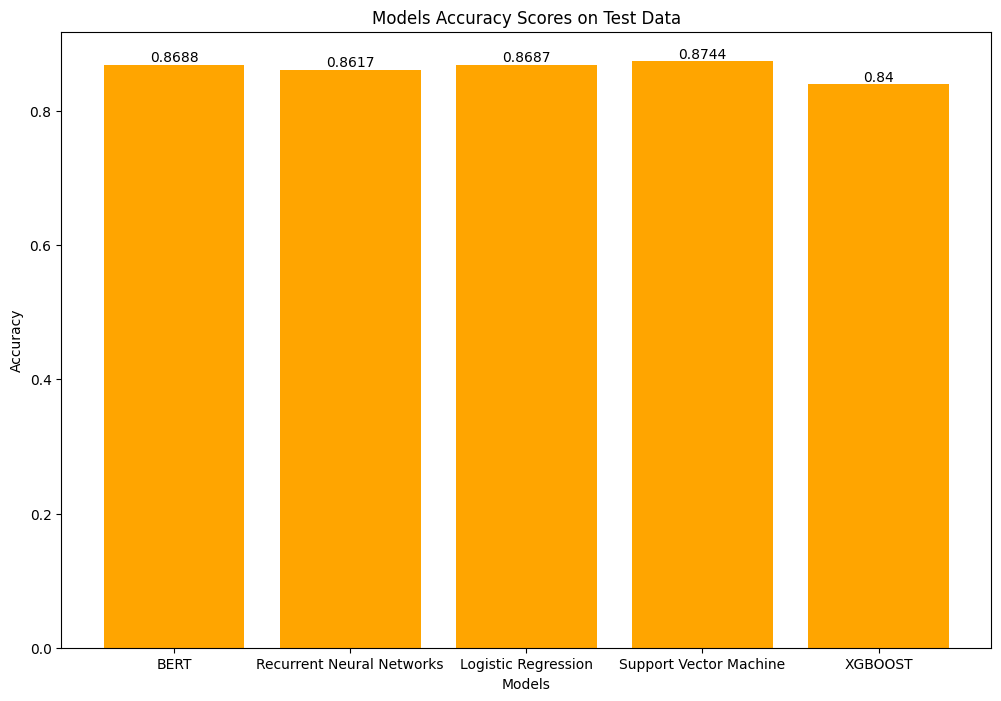

In [22]:
models = ["BERT", "Recurrent Neural Networks", "Logistic Regression", "Support Vector Machine", "XGBOOST"]
accuracies = [0.8688, 0.8617, 0.8687, 0.8744, 0.84]

plt.figure(figsize=(12, 8))
bars = plt.bar(models, accuracies, color='orange')

plt.title('Models Accuracy Scores on Test Data')
plt.ylabel('Accuracy')
plt.xlabel('Models')


for bar, accuracy in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(accuracy, 4), ha='center', va='bottom')

plt.show()